In [3]:
%load_ext autoreload
%autoreload 2

# Getting started with granite-geospatial-land-surface-temperature

This notebook demonstrates the usage of the granite-geospatial-land-surface-temperature model hosted on Hugging Face for the spatial downscaling of Land Surface Temperature (LST). Along with this getting_started notebook, we include 4 other notebooks which describe:

1. [introduction_to_LST_Tweening](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/2_introduction_to_LST_Tweening.ipynb): Temporal downscaling of LST (Tweening)

2. [tweening_data_preparation](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/3_tweening_data_preparation.ipynb): How to prepare a tweening dataset for new data downloaded

3. [download_data](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/4_download_data.ipynb): How to download HLS L30 and ERA5-Land for new cities

4. [preprocessing_data](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/notebooks/5_preprocess_data.ipynb): Preprocessing of the new data downloaded



The granite-geospatial-LST model is a fine-tuned Earth Observation Foundation Model (EOFM) that predicts LST from Harmonized Landsat and Sentinel-2 (HLS) L30 optical satellite imagery and ERA5-Land near-surface air temperature $(T_{2m})$. Ground truth LST used as target during training was calculated from the HLS L30 optical satellite imagery for 28 cities, representing a diverse set of bio-climatic zones across the globe. You can view the selected cities in the [model card](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/model-card.md). Note that we only use L30 data since Sentinel-2 satellites do not observe thermal radiation.” (Note: We restrict data used for fine-tuning and inference to acquisitions from Landsat only, since Sentinel satellites do not observe thermal radiation)

The fine-tuned LST model can be used to detect the Surface Urban Heat Island (SUHI) effect, which is defined by the higher temperatures experienced in built urban environments as opposed to their surrounding rural landscapes. The detection and characterization of SUHIs are important as the increased heat in the urban areas has several negative impacts on city operations, resource management, human health, and livelihoods.  Even though LST observations can be derived from detctors on satellites such as Landsat, MODIS, and EcoSTRESS, some of these data products and instruments vary in spatial resolution, may have limited temporal coverage, This fine-tuned model is a first step towards leveraging an EOFM to enable the ability to estimate LST maps at high spatial resolution and temporal frequency, which is beneficial for SUHI studies to quantify, detect and characterize SUHIs.     

Please see the [model card](https://github.com/ibm-granite/granite-geospatial-land-surface-temperature/blob/main/model-card.md) for more information on the model development, including the base foundation model. The input data contained 14 layers, 6 HLS band layers [B02-B07], 4 ERA5-Land ${T_2m}$ layers and sine and cosine of the Time-of-Day (TOD) and sine and cosine of the Day-of-Year (DOY) layers. The final model only utilised 7 layers: 6 HLS band layers [B02-B07] and the spatial mean of the ERA5-Land ${T_2m}$ at the time of acquisition. 

This notebook guides the user on the use of the granite-geospatial-LST model for:

1. __Inference:__ The granite-geospatial-LST model is loaded and applied to test examples (data from a city that it hasn't seen during fine-tuning) to produce an estimate of LST.
2. __Evaluate Predictions:__ Evaluate performance of all predictions across different dimensions, including location and over time.

The granite-geospatial-LST model weights are available from the Hugging Face IBM Granite Model Repository (LINK). The required data to complete the experiments in this notebook is available through Zenodo (LINK).

# Setting up your environment

The granite-geospatial-LST model is trained using the [Terratorch framework](https://github.com/IBM/terratorch/). Terratorch simplifies the integration of foundation model backbones into the TorchGeo framework and provides generic LightningDataModules that can be built at runtime. For more information on Terratorch, please refer to the instructions in the [Terratorch Quick Start Guide](https://ibm.github.io/terratorch/quick_start/).

## If running locally

Before running the notebook, make sure you have created a python environment and installed the directory granite-geospatial-LST using:

```
cd granite-geospatial-land-surface-temperature
pip install -e .
```

This will install pytorch and Terratorch for you, amongst a few other libraries.  Run the below cell if using this as a Colab notebook.

## If running on Colab

In [ ]:
import sys
if 'google.colab' in sys.modules:
  # Clone the ibm-granite/granite-geospatial-land-surface-temperature GitHub
  !git clone https://github.com/ibm-granite/granite-geospatial-land-surface-temperature.git
  # Install the package
  !pip install ./granite-geospatial-land-surface-temperature
  # Change to the notebooks directory

In [5]:
# If running on Colab you will be asked to restart the session. This is normal and you should do so.
# Only run this cell if running on Colab.
# Change to the notebooks directory
%cd granite-geospatial-land-surface-temperature/notebooks/
%pwd

/dccstor/eevdata/jamesz/Open_source_final/granite-geospatial-land-surface-temperature/notebooks


/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/dccstor/eevdata/jamesz/Open_source_final/granite-geospatial-land-surface-temperature/notebooks'

## Running the code

In [1]:
import os
import sys
import shutil
import glob
import yaml
import pandas as pd
import numpy as np
import subprocess
import json
import ipywidgets as widgets
from pathlib import Path
sys.path.append("../")


# Third Party
import rioxarray as rio
from lightning.pytorch import Trainer
from terratorch.cli_tools import LightningInferenceModel
import terratorch
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import tqdm
import tarfile
import urllib
if 'google.colab' in sys.modules:
  import gdown
  from google.colab import output
  output.enable_custom_widget_manager()

# First Party
from utils.plotting import plot_results
from utils.plotting import plot_rgb_lst_distribution_scatter
from utils.plotting import plot_box_plot
from utils.download_functions import write_config

from utils.plotting import advanced_plots

/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Model and data preparation

Let's start with downloading the model checkpoints and configs from HuggingFace:

In [3]:
# Download the model checkpoints, specify the path in local_dir
ckpt_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                            filename="LST_model.ckpt", 
                            local_dir="../")

# Download the configs, specify path save directory in local_dir
config_path_patches = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                                      filename="config.yaml", 
                                      local_dir="../")
config_path_full_tile = hf_hub_download(repo_id="ibm-granite/granite-geospatial-land-surface-temperature", 
                                        filename="config_full_tile.yaml", 
                                        local_dir="../")

Let's continue with downloading the datasets from Zenodo.  We will download two datasets - patched (2.69 GB) and full-tiles  (2.25 GB).  The model was trained on patches of size 224 x 224 from various cities and this format is also used for evaluating the model.  The model can inference on larger full-tile images also, and it's a good way to see the surface urban heat island effect across the full extent of a city.  Validation on the patches will be performed later in the notebook.

In [ ]:
# Specify path to where all data will be downloaded to
data_path = Path("../data")
data_path.mkdir(parents=True, exist_ok=True)

# Download and uncompress full-tile dataset from Zenodo 

dataset_fulltile_path = Path("../data/granite-geospatial-land-surface-temperature-dataset-full-tiles.tar.gz")

if 'google.colab' in sys.modules:
  try:
    gdown.download("https://drive.google.com/uc?id=15Ed1AcldcEyH-vaBCmr4I8BSbJoUGmQ9", str(dataset_fulltile_path))
  except:
    print(f"Download failed via g.down. Reverting to Zenodo.")
    !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset-full-tiles.tar.gz?download=1" -O {str(dataset_fulltile_path)}
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset-full-tiles.tar.gz?download=1" -O {str(dataset_fulltile_path)}

!tar -xf {str(dataset_fulltile_path)} --directory {str(data_path)}


inputs_path_full = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset-full-tiles/inputs/")
targets_path_full = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset-full-tiles/targets/")
predictions_path_full = data_path.joinpath("predictions-full-tiles/")
predictions_path_full.mkdir(parents=True, exist_ok=True)

# Download and uncompress patched dataset from Zenodo 
dataset_patched_path = Path("../data/granite-geospatial-land-surface-temperature-dataset.tar.gz")

if 'google.colab' in sys.modules:
  try:
    gdown.download("https://drive.google.com/uc?id=1_pMj9cYVZ8GKdXjFPYMvSqtFVqmxOFrY", str(dataset_patched_path))
  except:
    print(f"Download failed via g.down. Reverting to Zenodo.")
    !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset.tar.gz?download=1" -O {str(dataset_patched_path)}
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset.tar.gz?download=1" -O {str(dataset_patched_path)}

!tar -xf {str(dataset_patched_path)} --directory {str(data_path)}

if 'google.colab' in sys.modules:
  try:
    gdown.download("https://drive.google.com/uc?id=1_pMj9cYVZ8GKdXjFPYMvSqtFVqmxOFrY", str(dataset_patched_path))
  except:
    print(f"Download failed via g.down. Reverting to Zenodo.")
    !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset.tar.gz?download=1" -O {str(dataset_patched_path)}
else:
  !wget "https://zenodo.org/records/14034636/files/granite-geospatial-land-surface-temperature-dataset.tar.gz?download=1" -O {str(dataset_patched_path)}

!tar -xf {str(dataset_patched_path)} --directory {str(data_path)}

inputs_path_patch = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset/inputs/")
targets_path_patch = data_path.joinpath(f"granite-geospatial-land-surface-temperature-dataset/targets/")
predictions_path_patch = data_path.joinpath("predictions-patches/")
predictions_path_patch.mkdir(parents=True, exist_ok=True)

# Specify path to where results can be saved
results_path = data_path.joinpath(f"results/")
results_path.mkdir(parents=True, exist_ok=True)

## Run Inference on a couple of cities
For the first step, we use the granite-geospatial-land-surface-temperature model to inference on data from cities that the model hasn't seen during fine-tuning/training.  The data required for these inference examples should have been downloaded in the preceding cells, and saved in the path given by the `data_path` variable.  This inference step essentialy predicts LST at a $30 m$ resolution using the HLS L30 data and a $T_{2m}$ average from ERA5-Land.  We will make use of the `config_full_tile.yaml` config file provided in the `config` folder.

Note:  Running inference might take a couple of minutes if you are using CPU only.

In [7]:
# Run inference
conf = yaml.safe_load(Path(config_path_full_tile).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_full_tile,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', str(predictions_path_full), 
                     '--data.init_args.predict_data_root', str(inputs_path_full), 
                     '--data.init_args.predict_dataset_bands', data_bands,
                     '--data.check_stackability', str(False)])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {config_path_full_tile} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path_full)} --data.init_args.predict_data_root {str(inputs_path_full)} --data.init_args.predict_dataset_bands {data_bands} --data.check_stackability False"
#print(run_str)

/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Seed set to 0
/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/terratorch/models/prithvi_model_factory.py:75: UserWarning: PrithviModelFactory is deprecated. Please switch to EncoderDecoderFactory.
  warnings.warn("PrithviModelFactory is deprecated. Please switch to EncoderDecoderFactory.", stacklevel=1)
/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/lightning/pytorch/cli.py:683: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122/122 0:00:34 • 0:00:00 3.62it/s  3.60it/s 4m3.56it/s 


## Plot results
For the next step, we will plot some of the results obtained from the inference step.  This will include the following images: an RGB color composite from HLS, observed LST, predicted LST, and the error between prediction and observation.  We will plot 3 examples for the city of Baltimore.  The file name has the format of `city`_`country`.`tileID`.`date`.T`timestamp`.  The following files will be used:

1. baltimore_usa.T18SUJ.20160702.T104554 (a summer example)
2. baltimore_usa.T18SUJ.20180708.T104510 (another summer example)
3. baltimore_usa.T18SUJ.20191116.T104623 (a winter example)

2025-10-31 05:18:50,183 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96782607..21.95972].


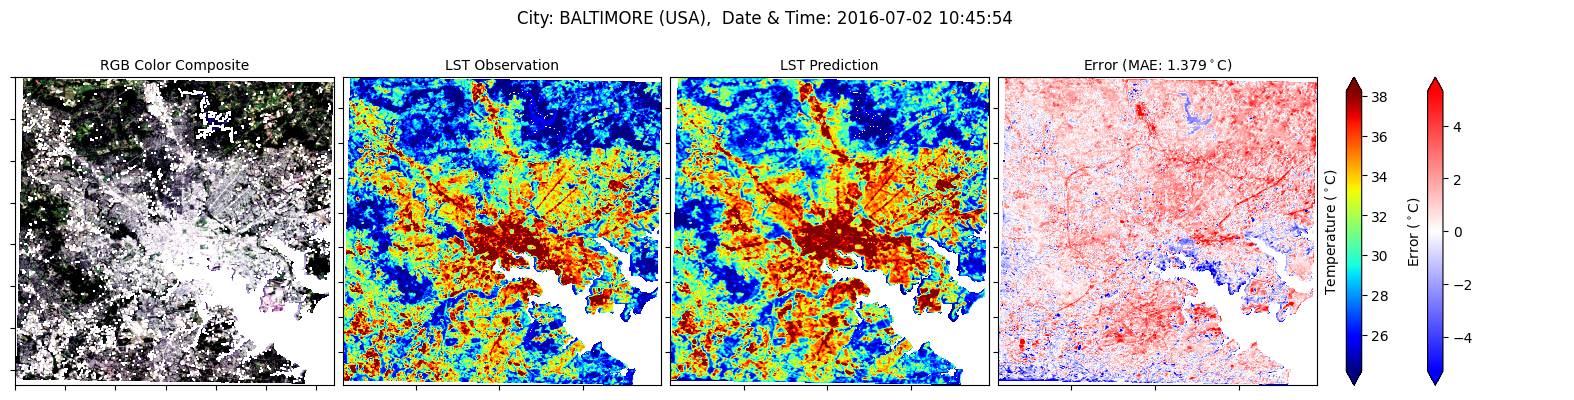

2025-10-31 05:18:53,797 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85816234..20.069378].


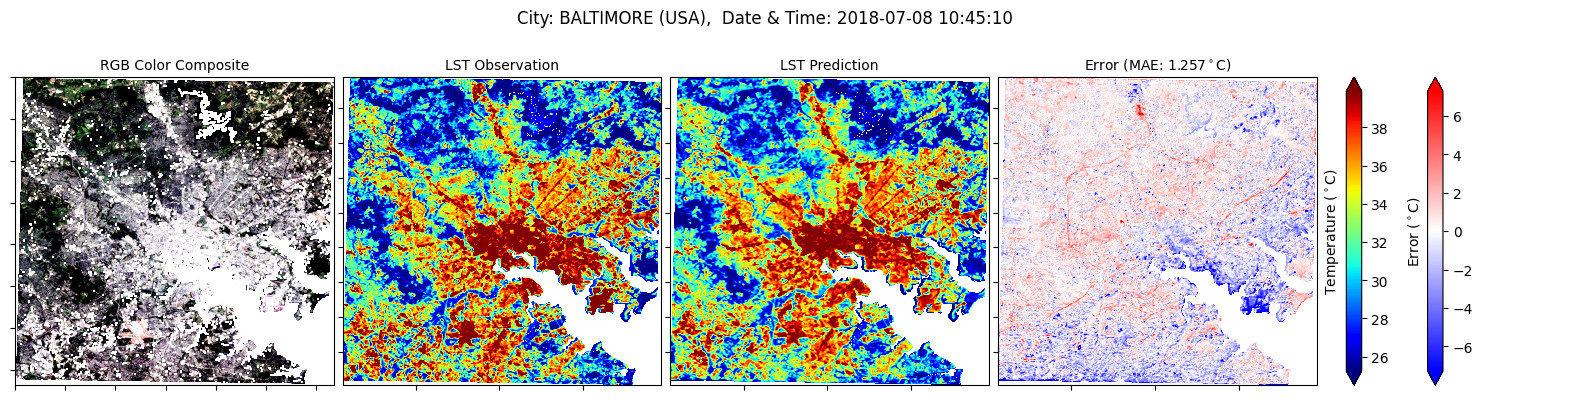

2025-10-31 05:18:57,393 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0026405..50.45858].


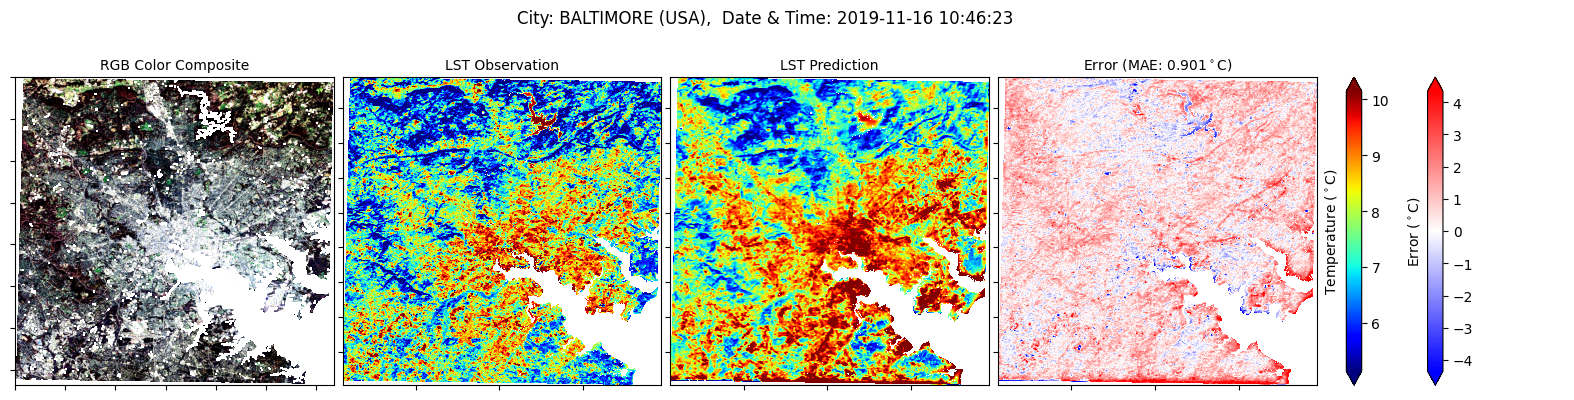

In [8]:
# Plot an example for Baltimore for summer
tile_name = "baltimore_usa.T18SUJ.20160702.T104554" # summer example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

# Plot another example for Baltimore for summer
tile_name = "baltimore_usa.T18SUJ.20180708.T104510" # summer example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

# Plot an example for Baltimore for winter
tile_name = "baltimore_usa.T18SUJ.20191116.T104623" # winter example
plot_results(tile_name, inputs_path_full, targets_path_full, predictions_path_full)

## Run Inference on more cities for evaluation
We will now run inference on a collection of patches downloaded earlier for 6 cities.  These cities are:  Johannesburg (South Africa), Paris (France), Dhaka (Bangladesh), Baltimore (USA), Havana (Cuba), and Porto (Portugal).  We will use the `config.yaml` file provided in the `configs` folder.

Note:  Running inference might take a couple of minutes if you are using CPU only.

In [9]:
# Run inference
conf = yaml.safe_load(Path(config_path_patches).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_patches,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', str(predictions_path_patch), 
                     '--data.init_args.predict_data_root', str(inputs_path_patch), 
                     '--data.init_args.predict_dataset_bands', data_bands,
                     '--data.check_stackability', str(False)])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {str(config_path_patches)} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path_patch)} --data.init_args.predict_data_root {str(inputs_path_patch)} --data.init_args.predict_dataset_bands {data_bands} --data.check_stackability False"
#print(run_str)

/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/lightning_utilities/core/imports.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Seed set to 0
/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/terratorch/models/prithvi_model_factory.py:75: UserWarning: PrithviModelFactory is deprecated. Please switch to EncoderDecoderFactory.
  warnings.warn("PrithviModelFactory is deprecated. Please switch to EncoderDecoderFactory.", stacklevel=1)
/u/jamesz/miniforge3/envs/climateEnv/lib/python3.10/site-packages/lightning/pytorch/cli.py:683: `PixelwiseRegressionTask.configure_optimizers` will be overridden by `MyLightningCLI.configure_optimizers`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint

Predicting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2413/2413 0:03:26 • 0:00:00 11.77it/s 11.77it/s m11.79it/s 


## Evaluate on multiple cities
We can now evaluate the model on the 6 cities mentioned above.  Three of these cities (Johannesburg, Paris, and Dhaka) are cities that the model has seen before during fine-tuning, but we use unseen timestamps as a held-out test set, which evaluates the model's ability to generalize over time.  The other cities (Baltimore, Havana and Porto) are locations that the model hasn't seen before and therefore evaluate the model across time and region. 

Note: This code block will take a few minutes to generate the plot as statistics are calculated on each patch and then aggregated per city. 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2413/2413 [02:38<00:00, 15.20it/s]


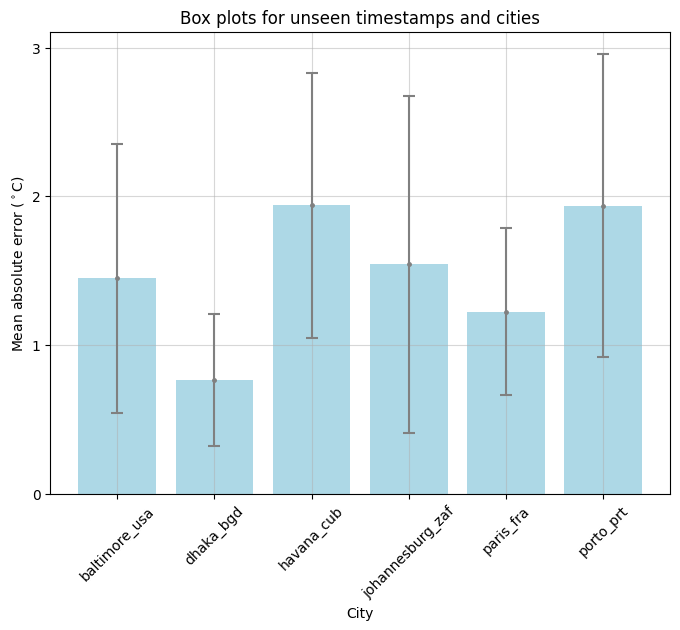

In [10]:
# Generate evaluation box plot
mdf = plot_box_plot(targets_path_patch, 
                    predictions_path_patch, 
                    results_path, 
                    save_plot=True)

These bar plots highlight that, overall, the model performance for unseen cities is on par with predictions for cities that the model was trained on, highlighting the generalisability of the model. This will be further demonstrated in the rest of the notebook patches/tiles from various seen and unseen cities are plottted and compared.

## Comparison plots
For the next step, the RGB composite image for the various patches/tiles for various cities are plottted along with the corresponding prediction, ground truth, error map, histogram and scatter plot to visualise the model performance. 

We will plot one prediction per city in the dataset:

Previously seen cities, but unseen timestamps:

1. dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs.tif
2. johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif
3. paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif

Previously unseen cities and time:

4. baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif
5. havana_cub.T17QLF.index_5_224.20230227.T105716.inputs.tif
6. porto_prt.T29TNF.index_2_224.20180821.T111312.inputs.tif

In [11]:
patches = ['dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs.tif',
           'johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs.tif',
           'paris_fra.T31UDP.index_0_224.20190704.T114044.inputs.tif', 
           'baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs.tif',
           'havana_cub.T17QLF.index_5_224.20230227.T105716.inputs.tif',
           'porto_prt.T29TNF.index_2_224.20180821.T111312.inputs.tif']

Results directory exits!
Creating comparison plots directory...


2025-10-31 05:26:14,918 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0023034..25.577908].


Saving plot ..... ../data/results/comparison_plots/dhaka_bgd.T46QBM.index_38_224.20221107.T102451.inputs_comp_plot_enhance.png


2025-10-31 05:26:16,513 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2858679..14.01755].


Saving plot ..... ../data/results/comparison_plots/johannesburg_zaf.T35JNM.index_10_224.20130426.T100951.inputs_comp_plot_enhance.png


2025-10-31 05:26:18,089 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9392274..23.063915].


Saving plot ..... ../data/results/comparison_plots/paris_fra.T31UDP.index_0_224.20190704.T114044.inputs_comp_plot_enhance.png


2025-10-31 05:26:19,657 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9057248..21.273928].


Saving plot ..... ../data/results/comparison_plots/baltimore_usa.T18SUJ.index_0_224.20131201.T104740.inputs_comp_plot_enhance.png


2025-10-31 05:26:21,253 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1368861..11.568309].


Saving plot ..... ../data/results/comparison_plots/havana_cub.T17QLF.index_5_224.20230227.T105716.inputs_comp_plot_enhance.png


2025-10-31 05:26:22,910 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2524734..15.164437].


Saving plot ..... ../data/results/comparison_plots/porto_prt.T29TNF.index_2_224.20180821.T111312.inputs_comp_plot_enhance.png


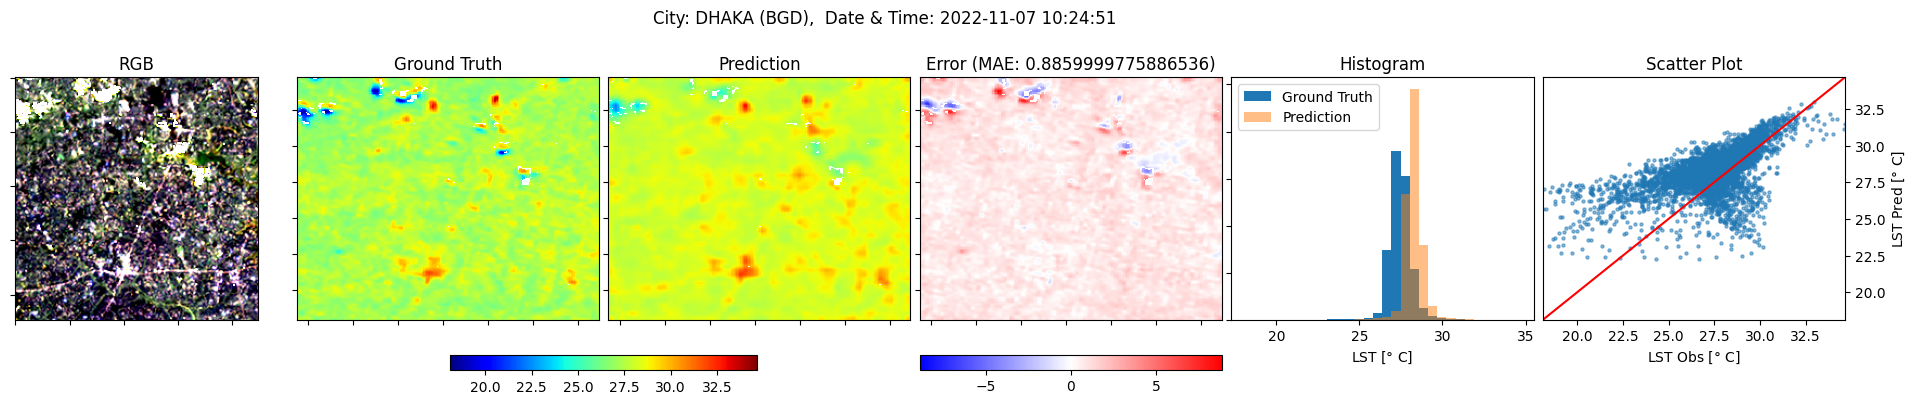

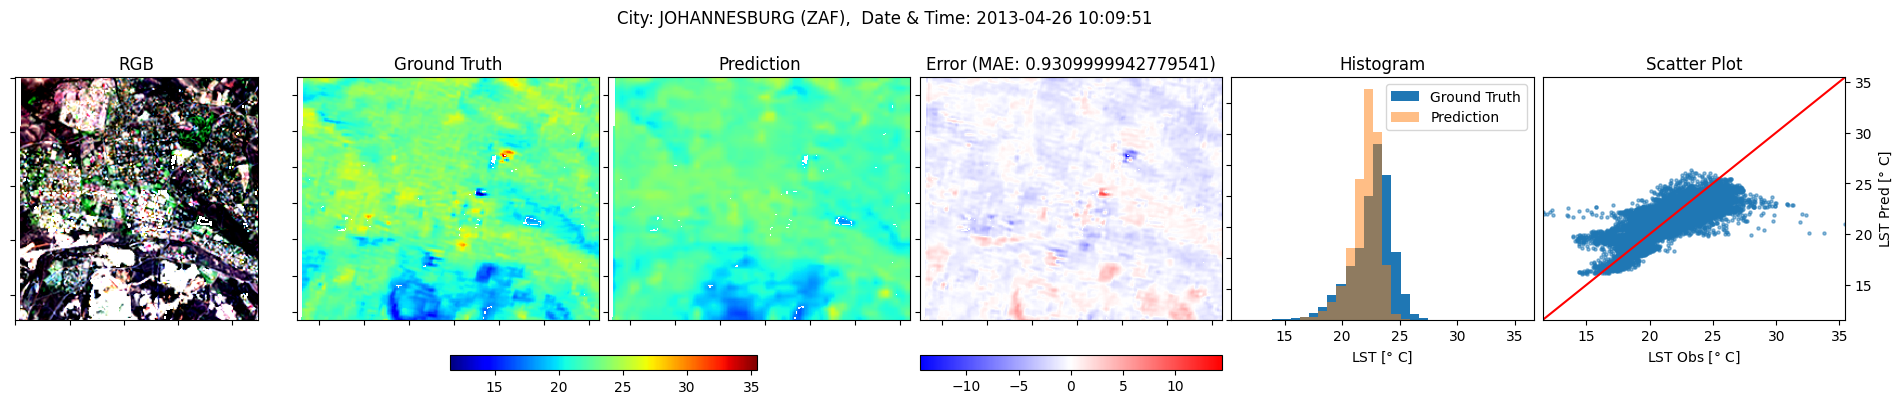

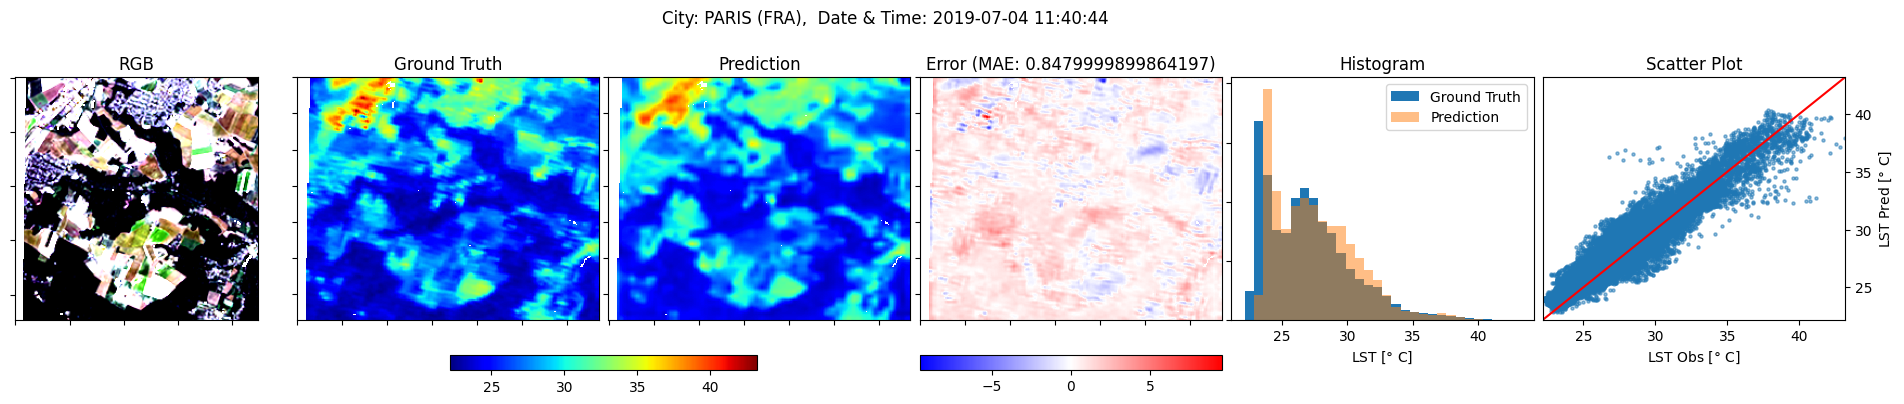

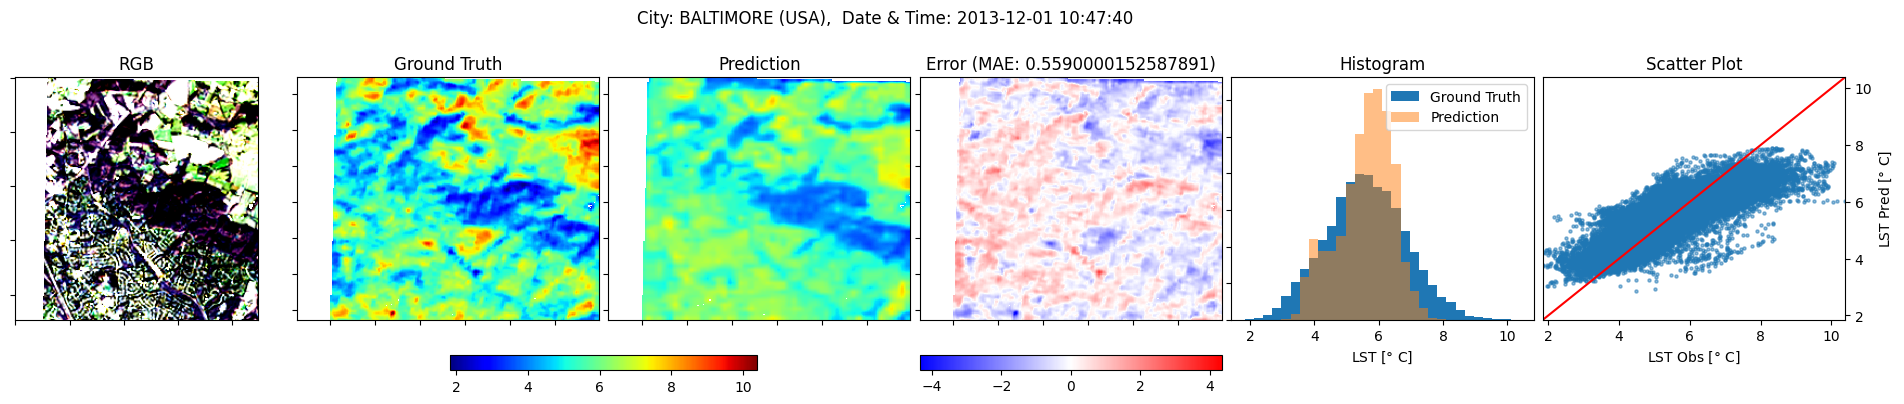

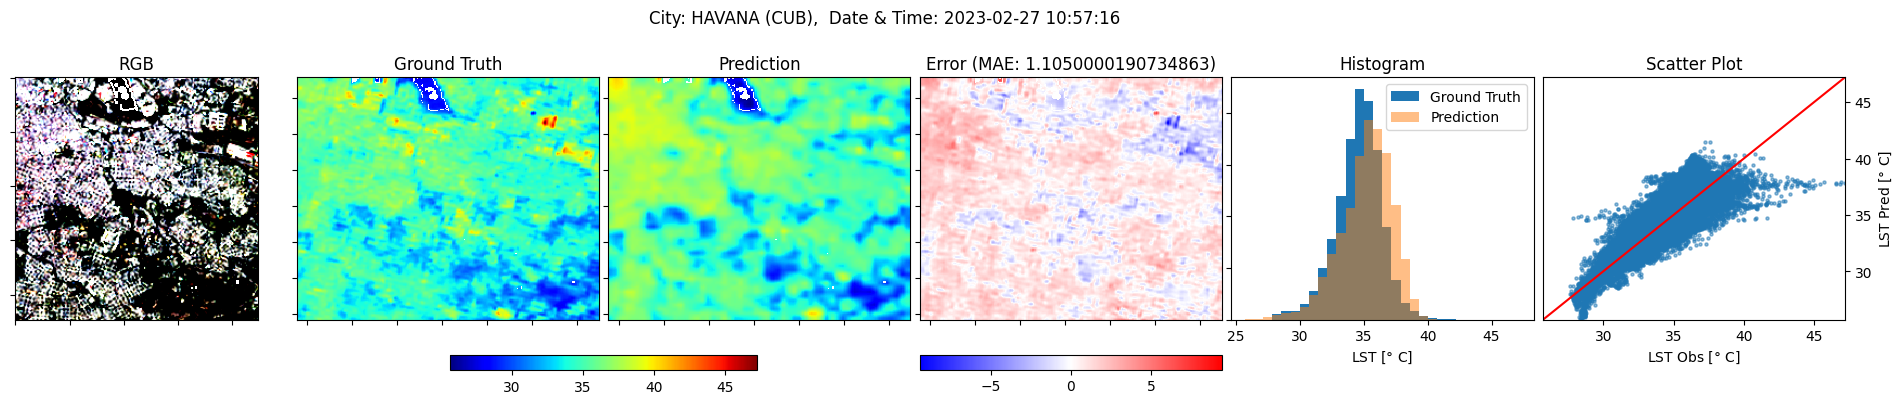

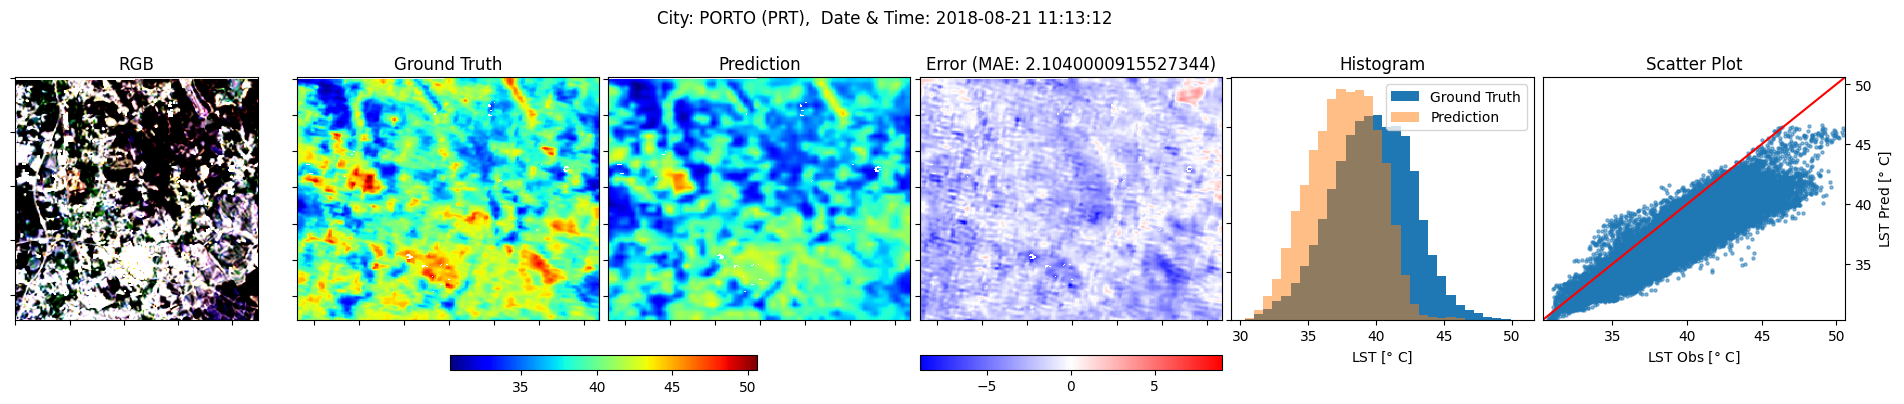

In [12]:
plot_rgb_lst_distribution_scatter(patches, 
                                  str(targets_path_patch), 
                                  str(predictions_path_patch), 
                                  str(results_path), 
                                  str(inputs_path_patch),
                                  patch=True,
                                  save_plot=True)

## **Try it for a new city of interest**
To run inference on the granite-geospatial-lst model for a new city, we would need to download and preprocess the relevant datasets. For this example we will consider a single city, over a few acquisitions. <br><br>
* **Note**: If you are considering downloading data for more than one city, over a long time period, ensure you have sufficient resources (run locally, not on Colab). Data download and preprocessing pipelines for these purposes are provided in the [download_data](./4_download_data.ipynb) and [preprocess_data](./5_preprocess_data.ipynb) notebooks. 

* Ensure you have a NASA Earthdata login and CDS API(Beta version) configured to proceed with the data download.

##### 1. Download data for a new region and period of interest

Set download parameters below.

In [13]:
#  City selection
df = pd.read_csv("../assets/databases/global_cities_database.csv", usecols =["CITY-NAME_ISO"])
print("Select the city-name_ISO you are interested in: ")

city_iso_name = 'aba_nga'
city_drop_down = widgets.Dropdown(options=df['CITY-NAME_ISO'],
                layout={'width':'max-content'},
                description='city-name:',
                disabled=False)

def dropdown_handler(change):
    global city_iso_name 
    city_iso_name = change.new 
city_drop_down.observe(dropdown_handler, names='value')

display(city_drop_down)

Select the city-name_ISO you are interested in: 


Dropdown(description='city-name:', layout=Layout(width='max-content'), options=('aba_nga', 'abbottabad_pak', '…

In [14]:
# Set additional parameters for data download

# Add max cloud cover percentage for HLS acquisition download. Recommended is < 30%.
hls_cc = 30.0   

# Enter start and end dates for data download, date format 'yyyy-mm-dd'
start_date = "2024-06-01" 
end_date = "2024-06-30" 

In [15]:
# Create config file using these parameters
write_config(city_iso_name, hls_cc, start_date, end_date)

Example config file saved in /utils/


Run download pipeline for the selection. This may take a few minutes depending on the dates selected and the CDS download queue.

In [ ]:
!python ../utils/main_download.py --configpath ../utils/config_download_example.json

##### 2. Preprocess the downloaded data to produce input and target patches. Edit the [config_preprocess](../utils/config_preprocess.json) file for the city you have just downloaded.

In [ ]:
!python ../utils/main_preprocess.py --configpath ../utils/config_preprocess.json

##### 3. Run inference on the examples processed

In [ ]:
# Run inference
conf = yaml.safe_load(Path(config_path_patches).read_text())
data_bands = "[" + ",".join([str(x) for x in conf['data']['init_args']['output_bands']]) + "]"
predictions_path = "../data/processed_data/predictions/"
os.makedirs(predictions_path, exist_ok=True)
inputs_path = "../data/processed_data/patched-inputs/"

_ = subprocess.call(['terratorch', 'predict', '-c', config_path_patches,
                     '--ckpt_path', str(ckpt_path), 
                     '--predict_output_dir', predictions_path, 
                     '--data.init_args.predict_data_root', inputs_path, 
                     '--data.init_args.predict_dataset_bands', data_bands,
                     '--data.check_stackability', str(False)])

# If the above block of code using subprocess.call does not work, use the string stored in run_str to do the inferencing via the CLI.
#run_str = f"terratorch predict -c {config_path_patches} --ckpt_path {str(ckpt_path)} --predict_output_dir {str(predictions_path)} --data.init_args.predict_data_root {str(inputs_path)} --data.init_args.predict_dataset_bands {data_bands} --data.check_stackability False"
#print(run_str)


#### 4. Visualize the predictions

In [ ]:
inputs_path = "../data/processed_data/patched-inputs/"
targets_path = "../data/processed_data/patched-targets/"


patches = [glob.glob(os.path.join(inputs_path, "*.tif"))[0].split("/")[-1]] #index 0 plots only the first example
results_path = "../data/processed_data/results/"
os.makedirs(results_path, exist_ok=True)

plot_rgb_lst_distribution_scatter(patches, 
                                  targets_path, 
                                  predictions_path, 
                                  results_path, 
                                  inputs_path,
                                  patch=True, 
                                  save_plot=True)

# Data preparation for more advanced plots
We will now process our data for more advanced plots.


In [ ]:
advanced_plts = advanced_plots(inputs_path_patch,targets_path_patch,predictions_path_patch)
advanced_plts.proccess_city_data()

 The rolling average MAE plot gives us an indication of the model's performance across different seasons.

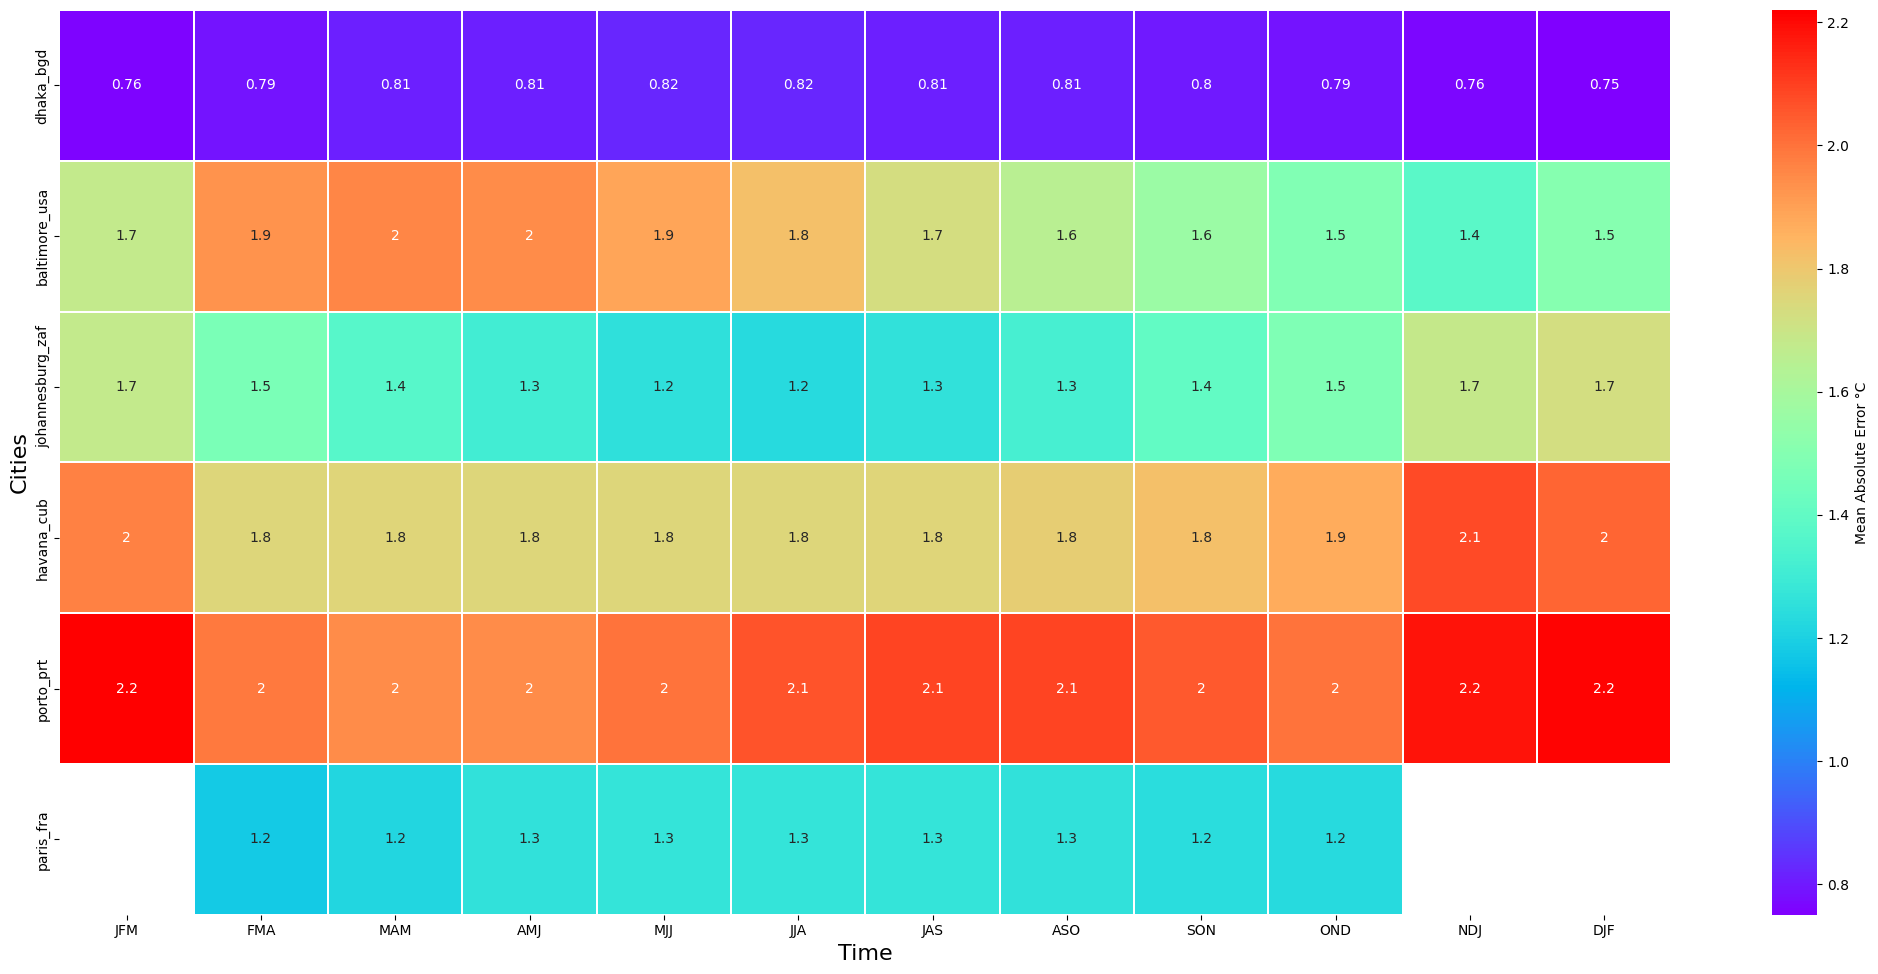

In [6]:
advanced_plts.rolling_mae_plot()

 Density function scatter plot

                  Correlation
havana_cub           0.899559
dhaka_bgd            0.962423
johannesburg_zaf     0.966350
porto_prt            0.976959
baltimore_usa        0.985559
paris_fra            0.987081


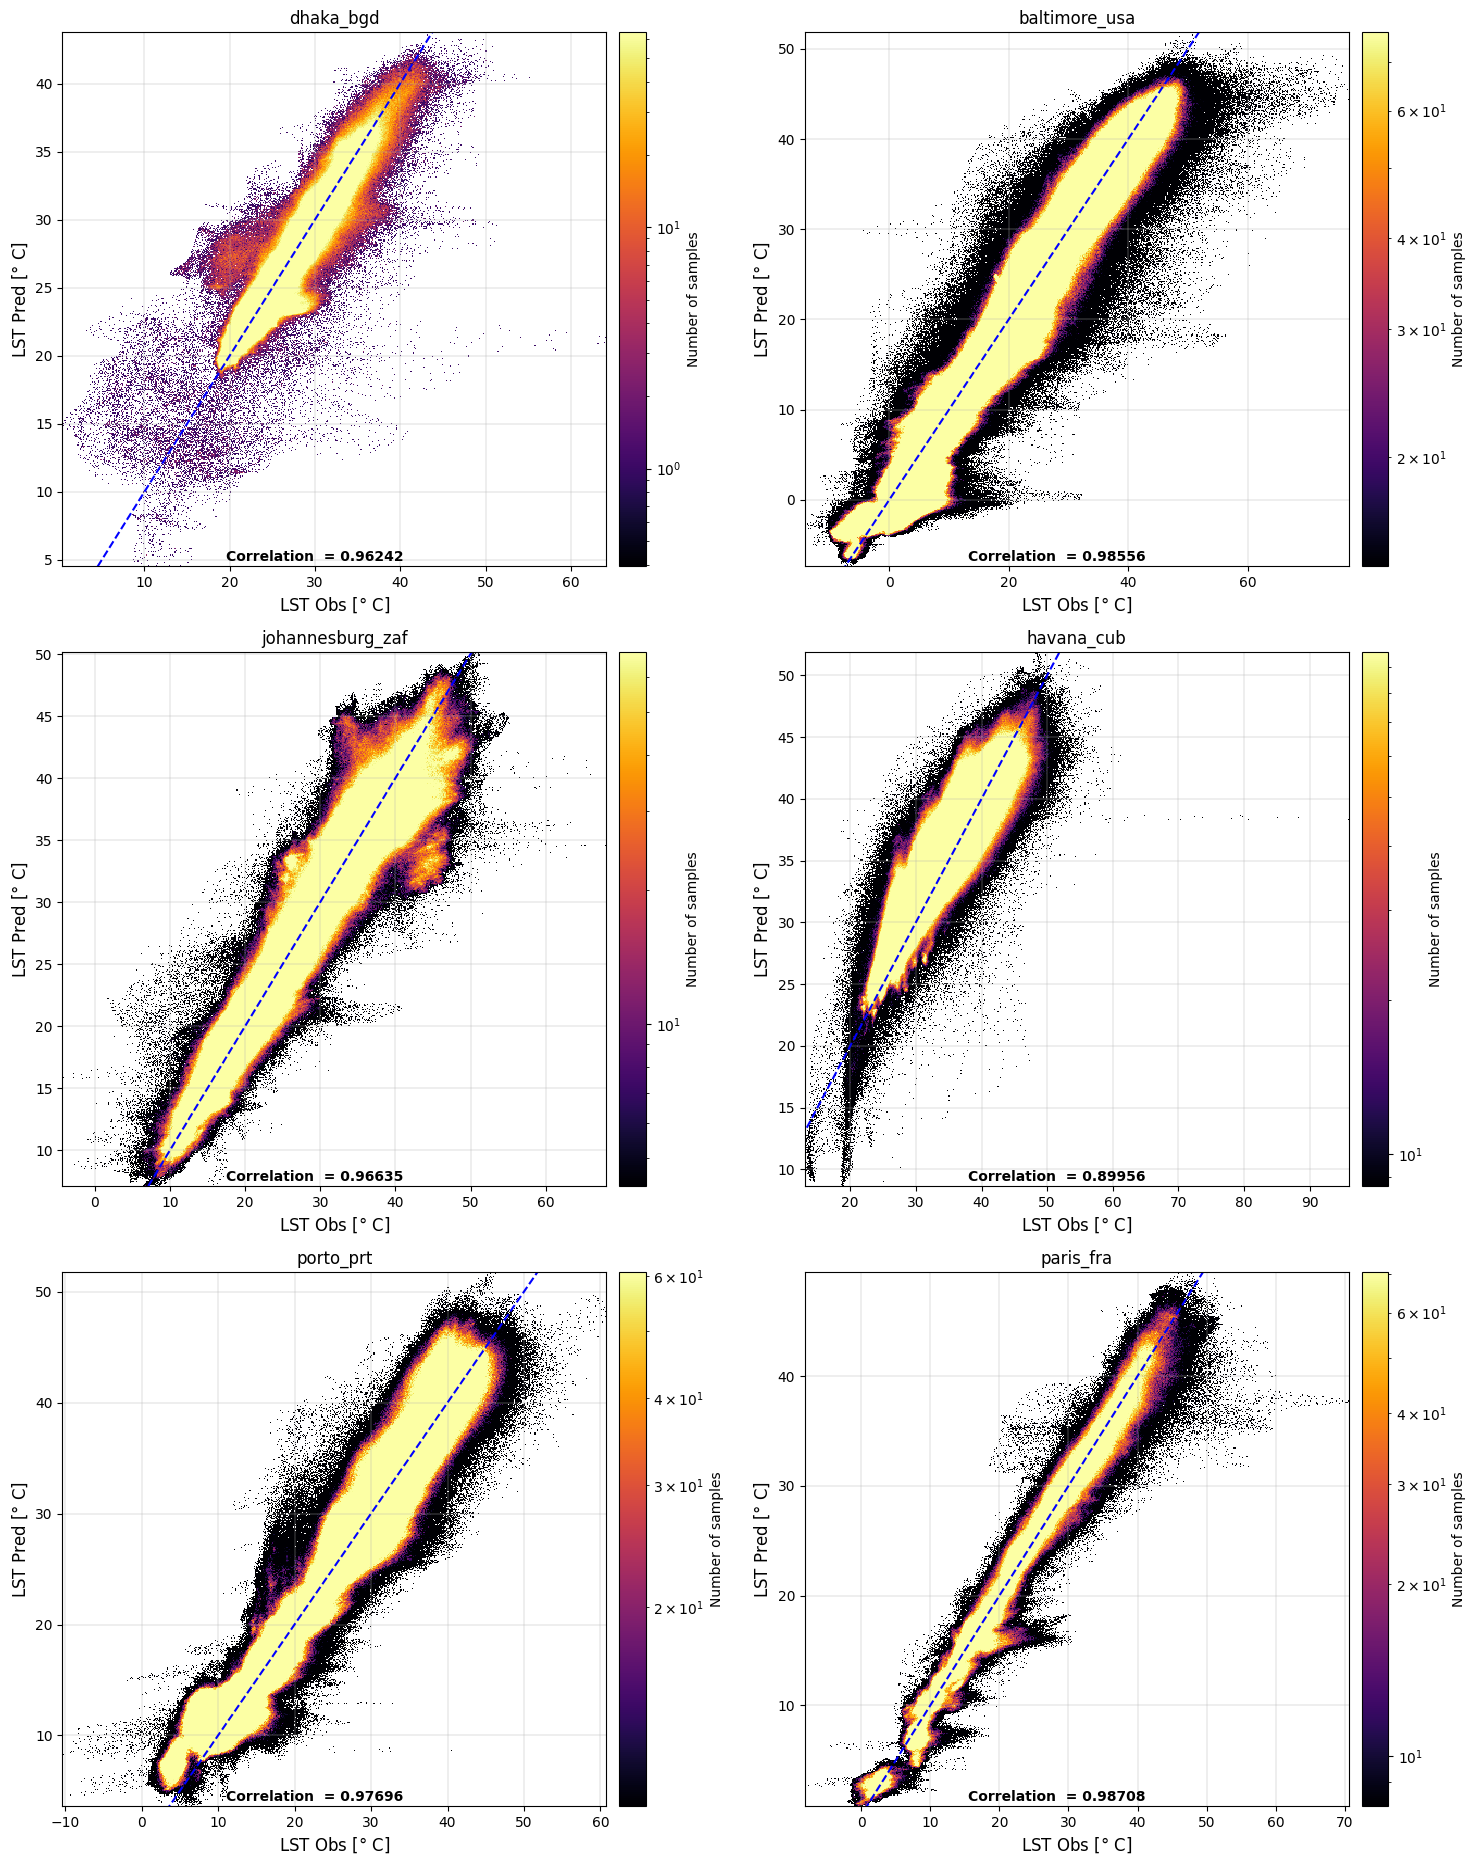

In [7]:
advanced_plts.density_scatter_plots()

To understand how a city's climate may affect the model's performance, we group the cities according to their Koppen-Geiger climate classification. Below are some sample plots.

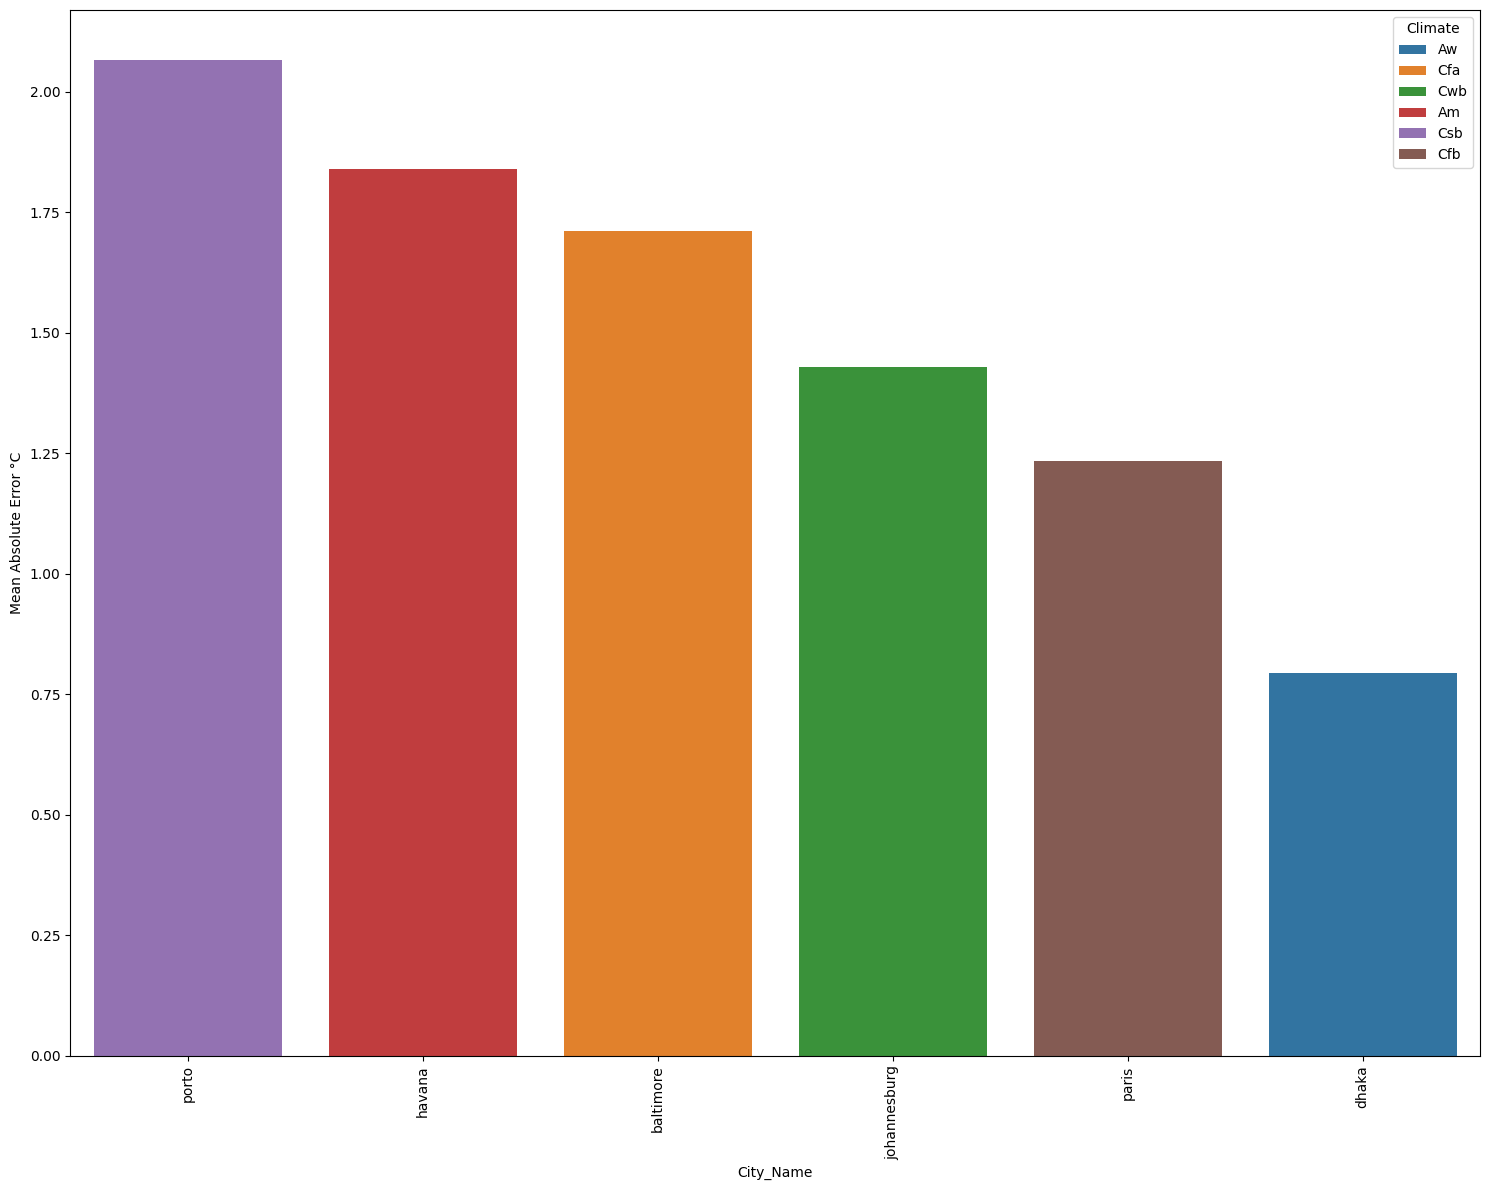

In [8]:
advanced_plts.first_climate_info_plot()

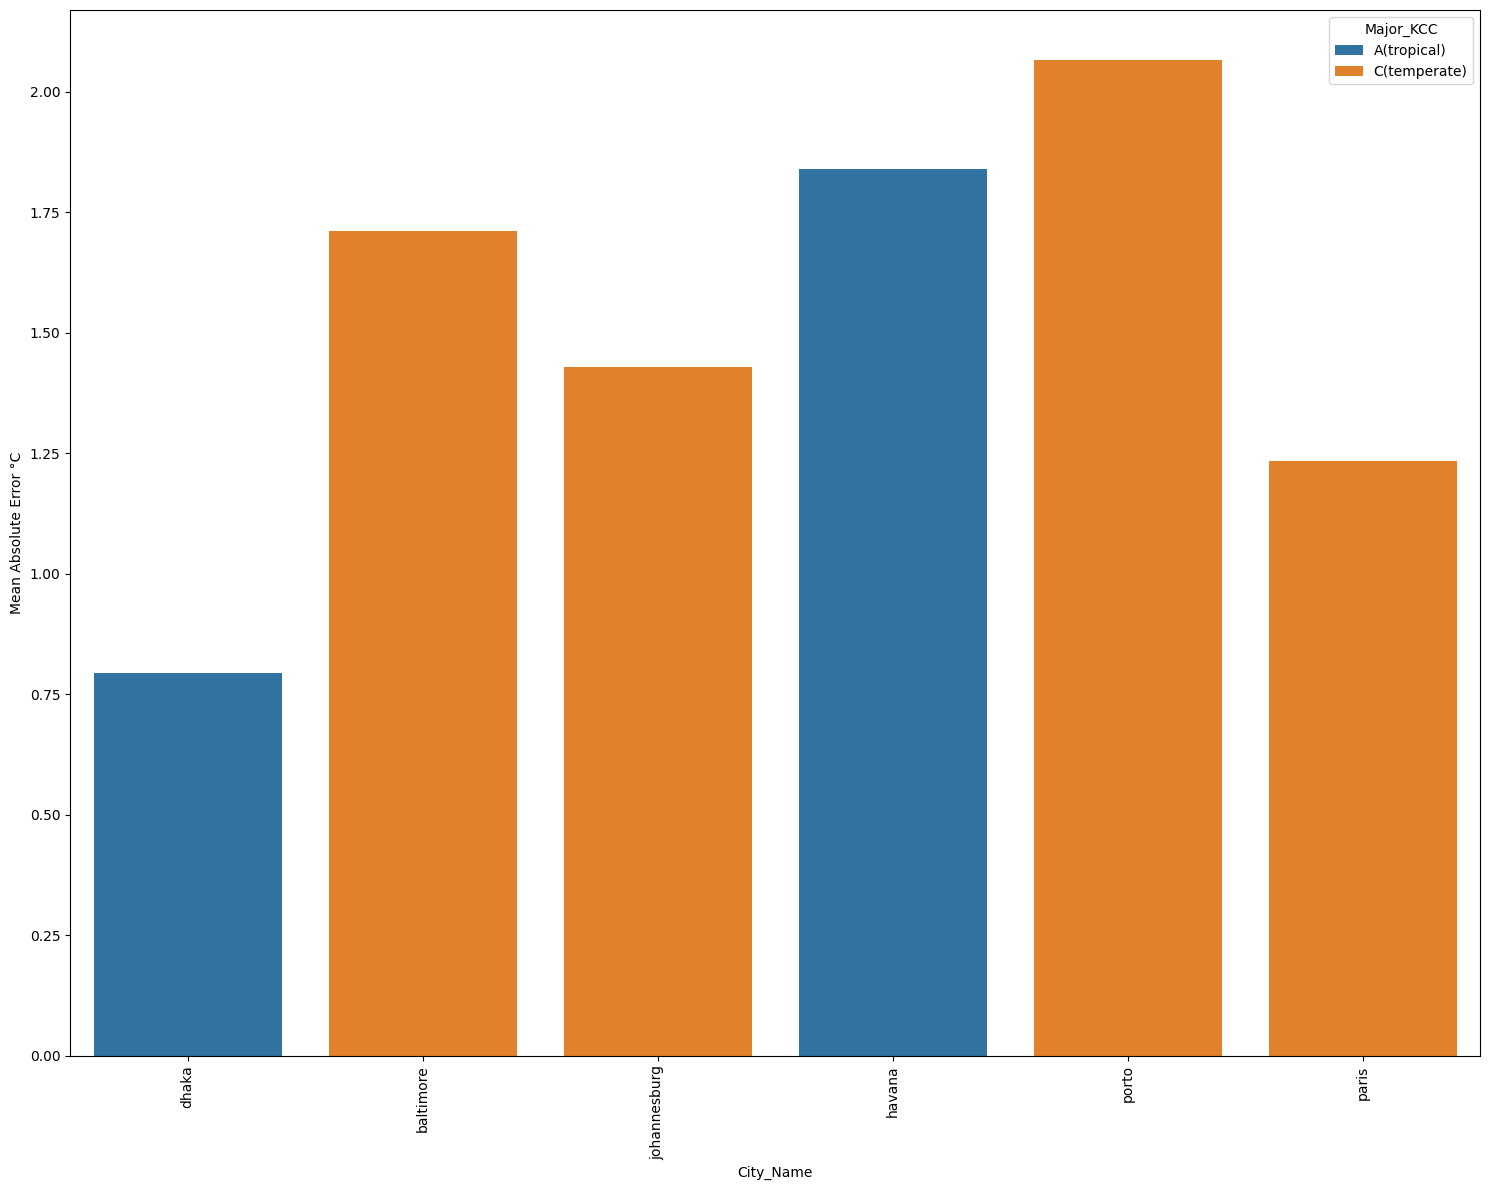

In [10]:
advanced_plts.third_climate_info_plot()

2025-10-31 06:06:22,578 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-31 06:06:22,582 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


              Mean_Absolute_Error Num_of_input_samples
Major_KCC                                             
A(tropical)              1.316597                  422
C(temperate)             1.610399                 1991


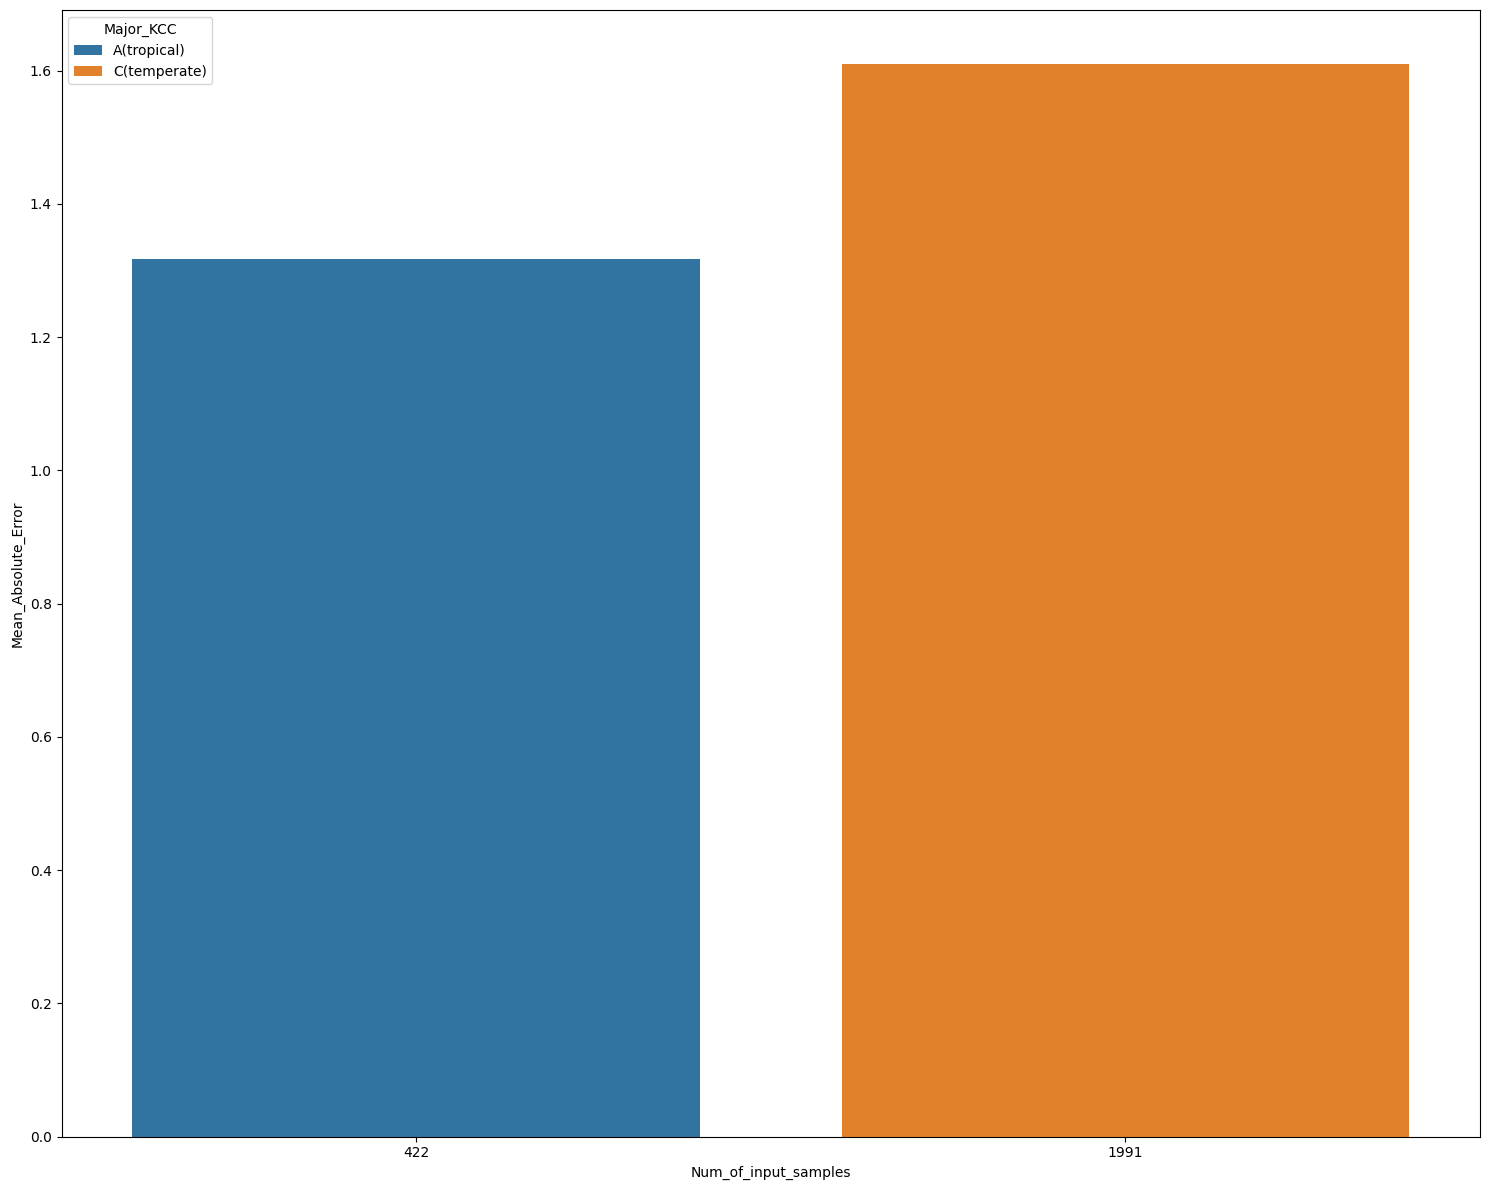

In [11]:
advanced_plts.forth_climate_info_plot()

For spatial interpretation, we will now generate spatial plots using T2m data for each climate classification.

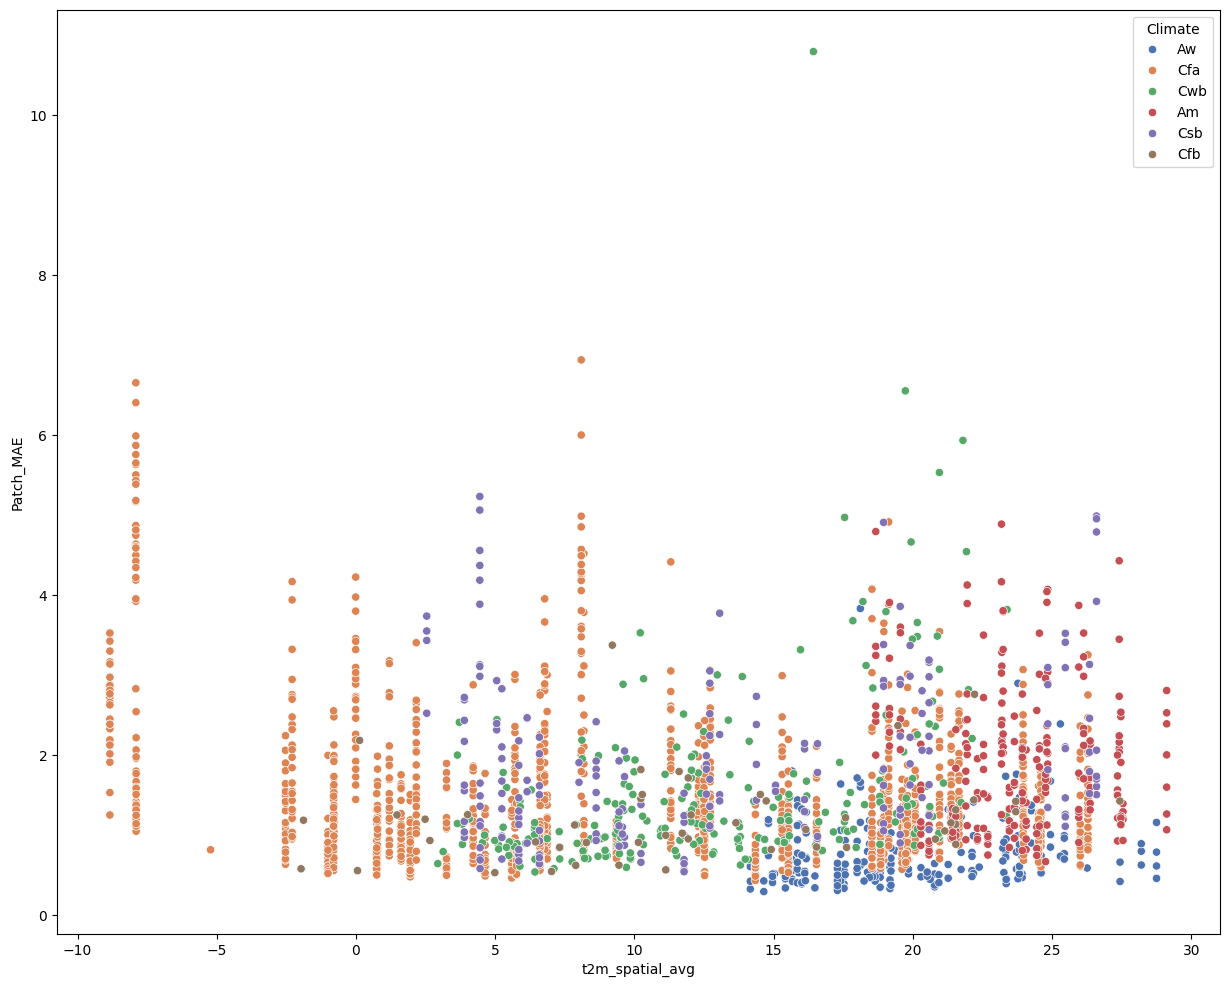

In [12]:
advanced_plts.t2m_scatter_plot()

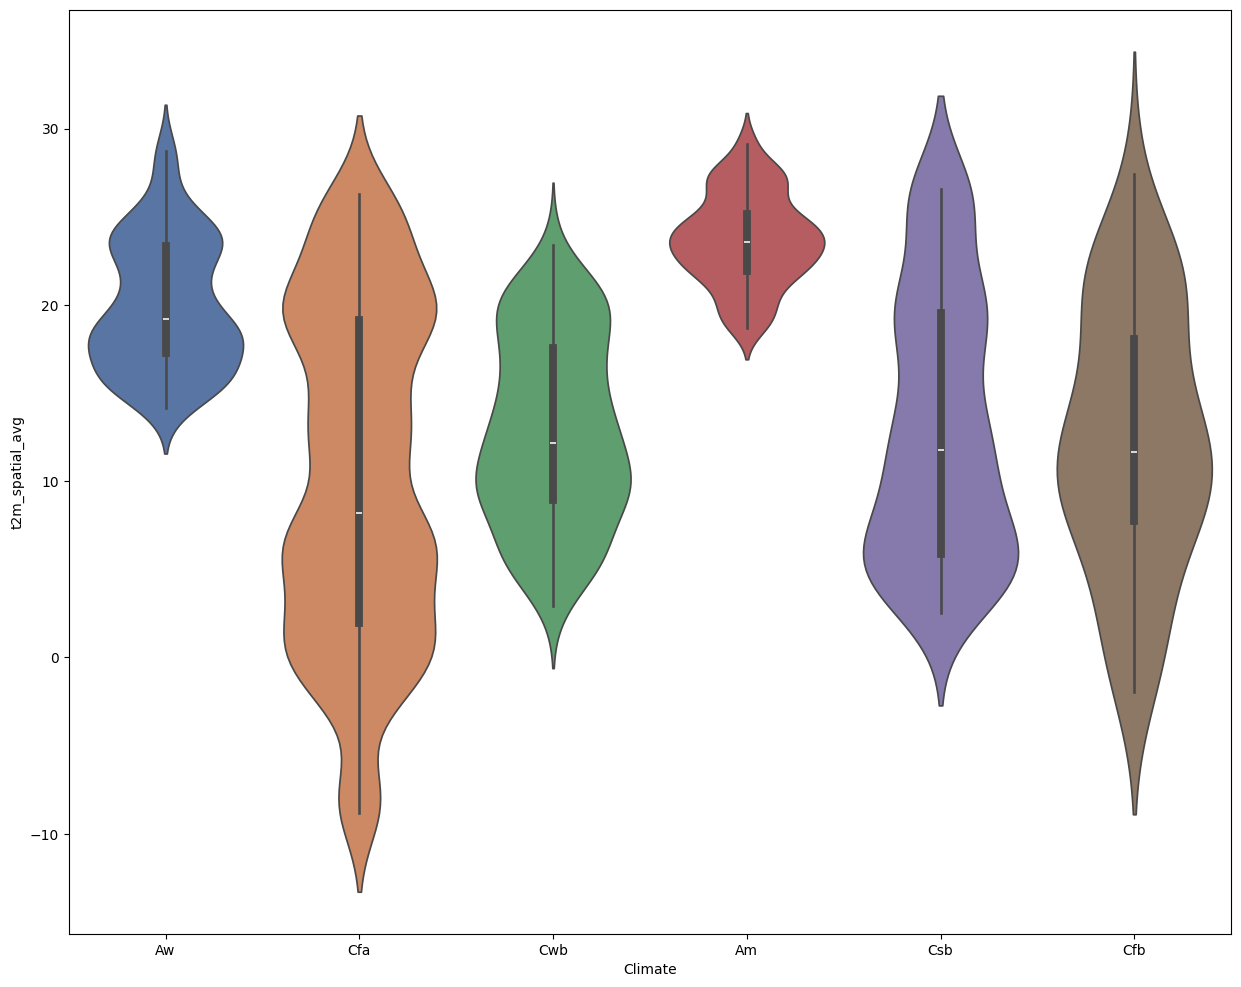

In [13]:
advanced_plts.t2m_violin_plot()

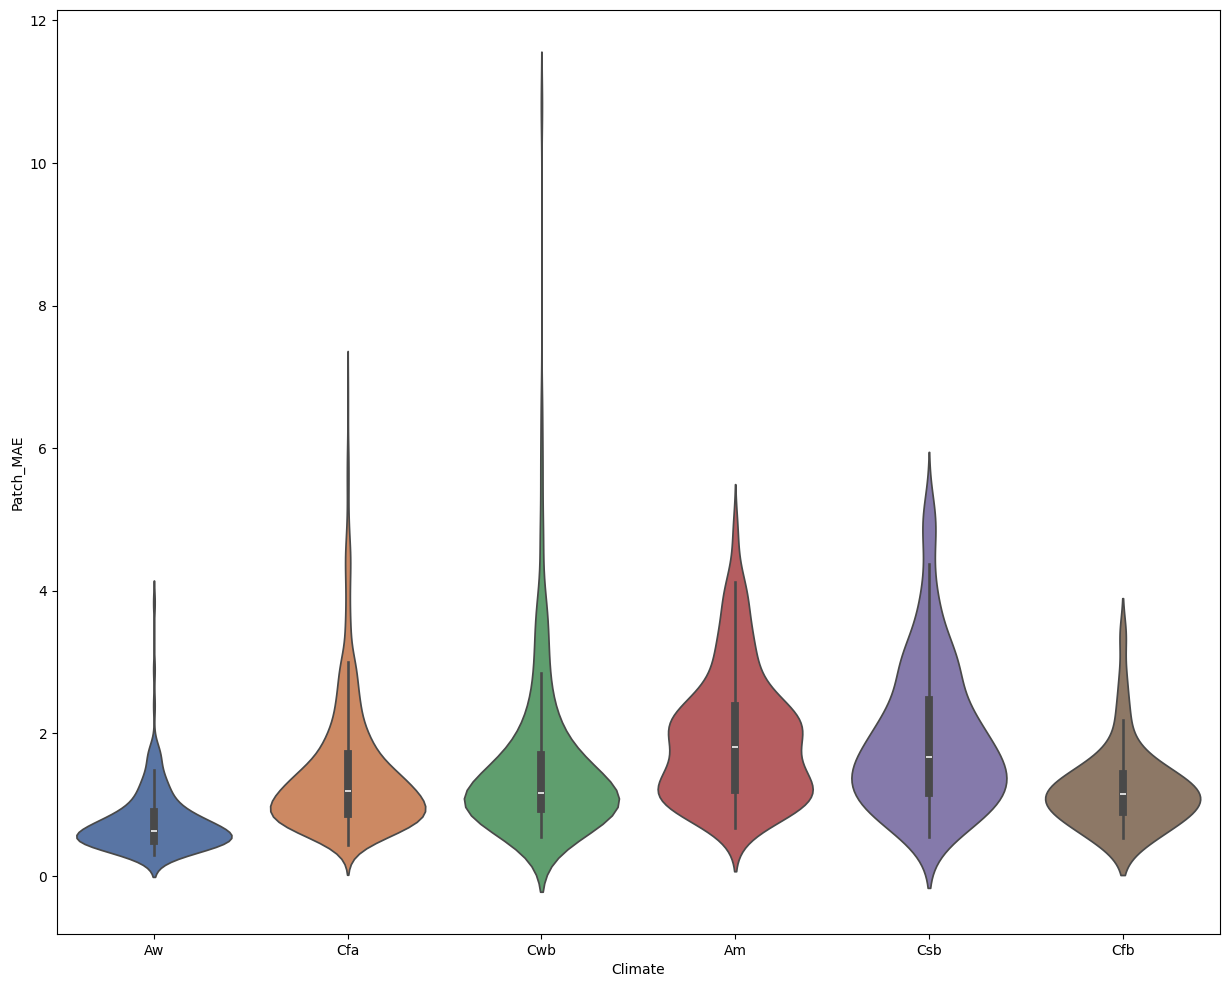

In [14]:
advanced_plts.t2m_patch_mae()

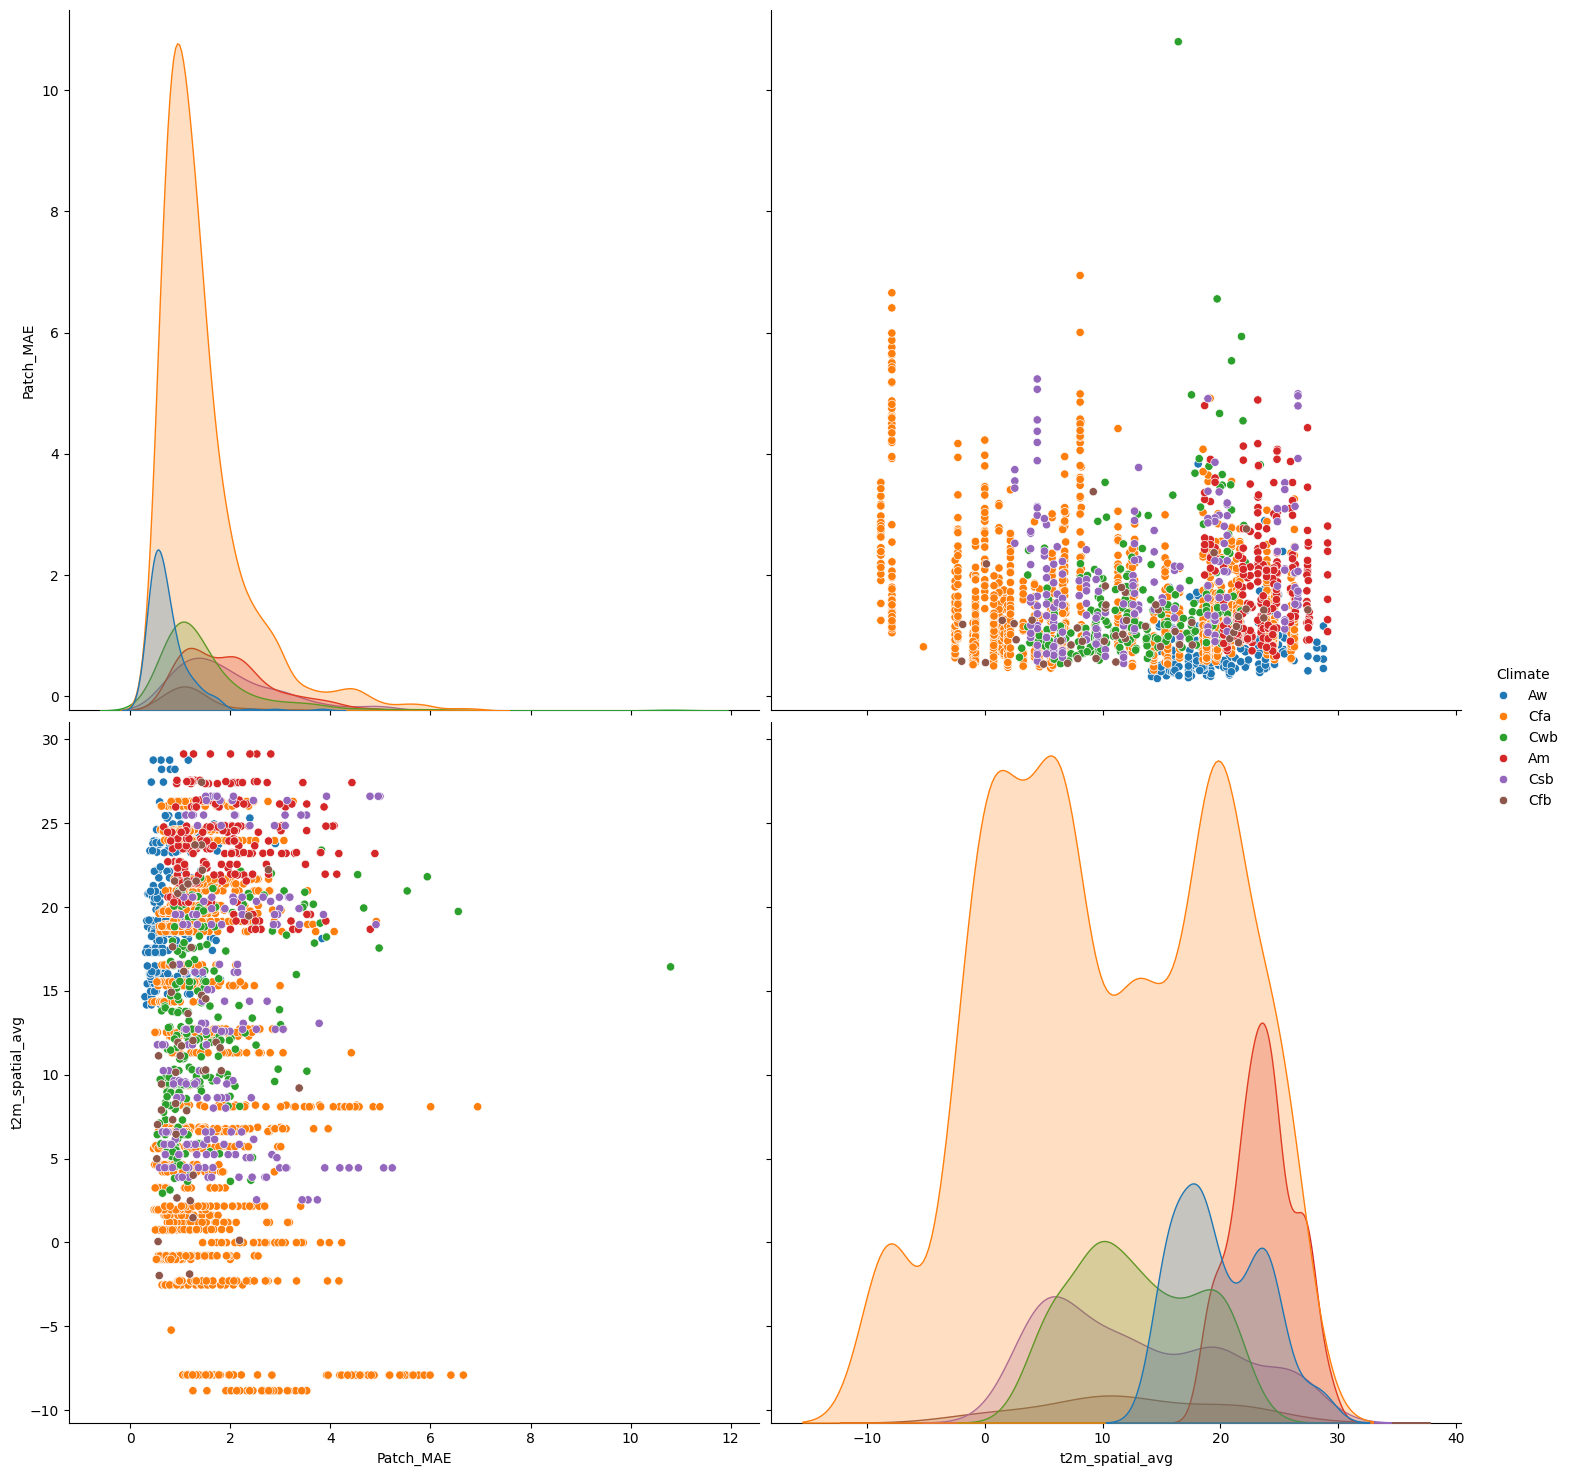

In [15]:
advanced_plts.t2m_pair_plot()

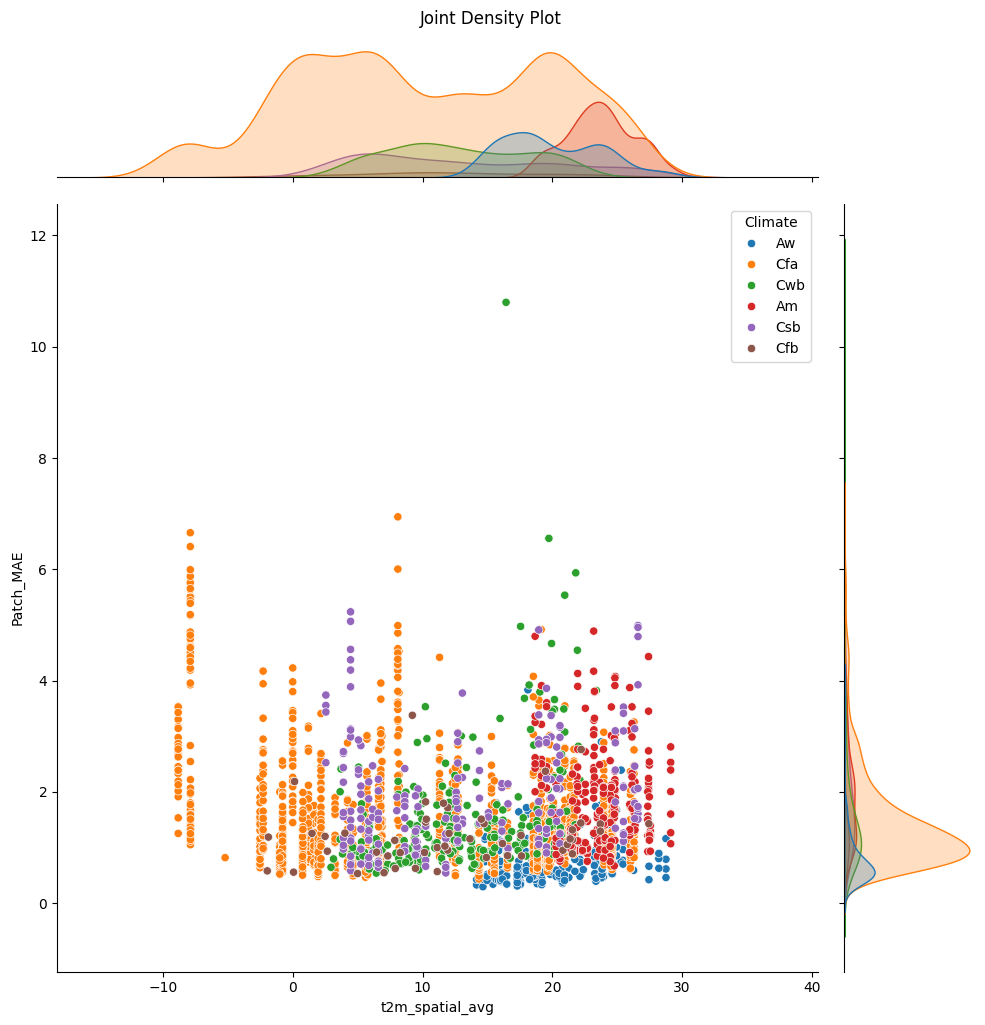

In [ ]:
advanced_plts.t2m_joint_plot()